## Analyse and Classify Domains

In this notebook, we will analyse and classify the domains retrieved from the processing steps.

We now have in our hands a list of domains for each video and a sponsor score determining if the video description contains a sponsorship-related theme. We do the following:

1. Firstly, we perform an overall analysis of the domains and find their average sponsor score.

2. In a second step, we take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine if they are sponsor-related or not. In this step, the average sponsor score might be a good indicator.

3. We perform an analysis on these popular domains.

In [1]:
import findspark
findspark.init()

import numpy as np
import seaborn as sns

from pyspark.sql.functions import explode, udf, count, collect_list
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

plt.style.use('ggplot')

### Broad Domain Analysis

From our previous domain and sponsor score analysis, we will merge them together to analyse the domains.

In [2]:
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_en_domains.parquet'
PATH_METADATAS_SPONSOR_SCORES_SRC = '../data/generated/yt_metadata_en_sponsor_scores.parquet'

In [3]:
# Join the datasets together
metadatas_domains = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC)
metadatas_sponsor_scores = spark.read.parquet(PATH_METADATAS_SPONSOR_SCORES_SRC)
metadatas = metadatas_domains.join(metadatas_sponsor_scores, on='display_id', how='left')

In [ ]:
assert metadatas.count() == metadatas_domains.count()

In [4]:
# We have all needed features for the domain analysis
metadatas.dtypes

[('display_id', 'string'),
 ('categories', 'string'),
 ('channel_id', 'string'),
 ('dislike_count', 'int'),
 ('duration', 'int'),
 ('like_count', 'int'),
 ('tags', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('view_count', 'bigint'),
 ('domains', 'array<string>'),
 ('domains_count', 'int'),
 ('has_domains', 'string'),
 ('sponsor_score', 'int')]

In [4]:
metadatas.select('display_id', 'domains', 'sponsor_score').show(5)

+-----------+--------------------+-------------+
| display_id|             domains|sponsor_score|
+-----------+--------------------+-------------+
|82fVA65rbts|           [radi.al]|            2|
|Hpxh4XBQBEk|[whatcar.com, sma...|            9|
|K308-reAiTk|[linyibrickmachin...|            2|
|Qit2N489qqk|[whatcar.com, the...|            9|
|VFwTdmiqlmM|[iteachstamping.c...|            1|
+-----------+--------------------+-------------+
only showing top 5 rows



In [4]:
# Group every domain and count the number of videos that contain it.
domains_count = metadatas \
    .select(explode('domains').alias('domain')) \
    .groupBy('domain') \
    .count() \
    .orderBy('count', ascending=False)

In [5]:
total_counts = domains_count.select('count').collect()
total_counts = [c[0] for c in total_counts]

print(f"There are a total of {len(total_counts)} domains.")

There are a total of 1077304 domains.


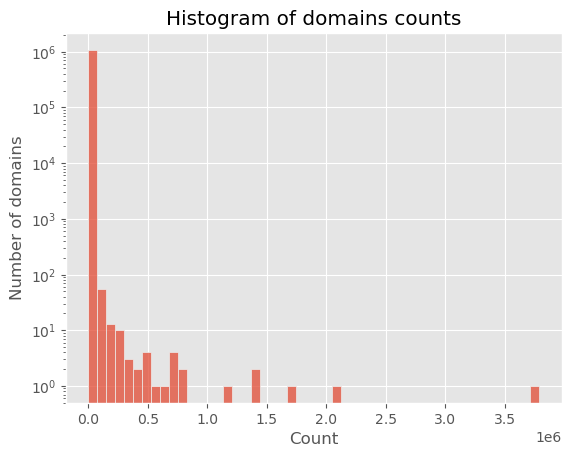

In [6]:
sns.histplot(total_counts, bins=50)
plt.yscale('log')
plt.title('Histogram of domains counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

There are about $1$ million distinct domains in the entire dataset. The distribution of the number of videos each domain occurs in is shown above. It seems to be **heavily right-skewed**, with a few domains occurring in a large number of videos.

### Domain Analysis on Popular Domains

Since there are so many domains, we will only focus on the most popular ones by filtering out the domains that occur in less than $10'000$ videos. Each video has a list of domains and a sponsor score, we can therefore infer a sponsor score for each popular domain by taking the median of the video sponsor scores containing the domain.

In [7]:
def find_median(values_list):
    try:
        median = np.median(values_list)
        return round(float(median), 2)
    except Exception:
        return None

In [8]:
MIN_DOMAIN_COUNT = 10_000

median_udf = udf(find_median, FloatType())

# Group every domain, count the number of videos that contain it and compute the median sponsor score.
domains_top_count = metadatas \
    .select(explode('domains').alias('domain'), 'sponsor_score') \
    .groupBy('domain') \
    .agg(count('domain').alias('count'), collect_list('sponsor_score').alias('sponsor_scores')) \
    .filter(f'count >= {MIN_DOMAIN_COUNT}') \
    .withColumn('median_sponsor_score', median_udf('sponsor_scores')) \
    .drop('sponsor_scores') \
    .orderBy('count', ascending=False)

In [9]:
domains_top_count.show(10)

+-------------------+-------+--------------------+
|             domain|  count|median_sponsor_score|
+-------------------+-------+--------------------+
|    plus.google.com|3786647|                 3.0|
|    play.google.com|2093786|                 4.0|
|   itunes.apple.com|1724603|                 3.0|
|             bit.ly|1408414|                 3.0|
|        tinyurl.com|1380122|                 4.0|
|          rstyle.me|1175073|                11.0|
| steamcommunity.com| 824573|                 3.0|
|creativecommons.org| 767740|                 4.0|
|        smarturl.it| 750397|                 3.0|
|              po.st| 739548|                 4.0|
+-------------------+-------+--------------------+
only showing top 10 rows



In [10]:
top_counts = domains_top_count.select('count').collect()
top_counts = [c[0] for c in top_counts]

print(f"There are a total of {len(top_counts)} domains with at least {MIN_DOMAIN_COUNT} counts.")

There are a total of 1000 domains with at least 10000 counts.


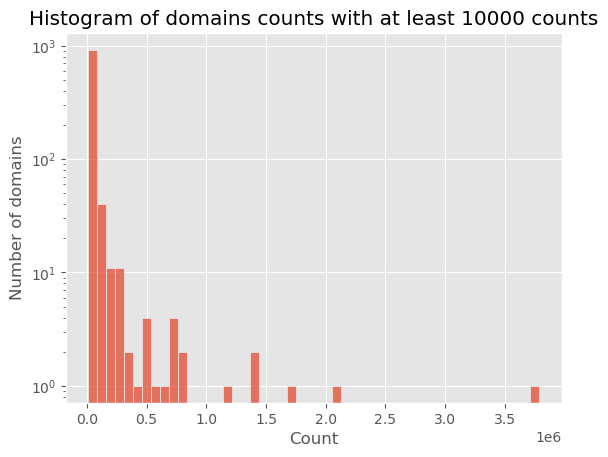

In [11]:
sns.histplot(top_counts, bins=50)
plt.yscale('log')
plt.title(f'Histogram of domains counts with at least {MIN_DOMAIN_COUNT} counts')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

Both distributions are **heavy-tailed to the right**. Indeed, there are many domains that appear in some videos only and a small subset of domains seem to prevail in many videos. This is a typical feature of a **power-law distributions**. The **log-log plot** of the distribution of the number of videos per domain is shown below.

Taking only domains that appear in at least $10'000$ videos does not change much the distribution as it might still be considered as a small amount of occurence for a domain. Nevertheless, we end up with only $1'000$ distinct domains to take into account, which is a reasonable amount of data to work with.

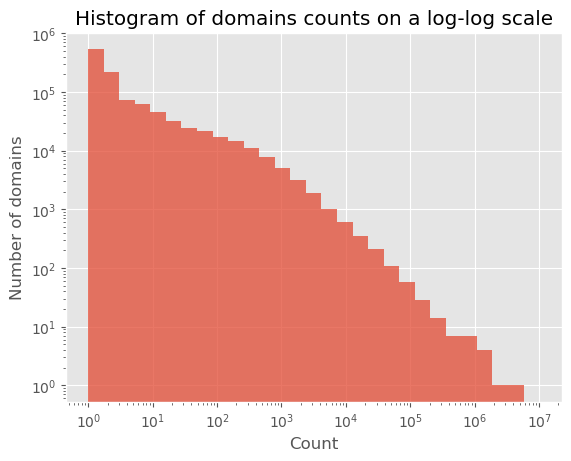

In [12]:
sns.histplot(total_counts, bins=np.logspace(0, 7, 30))
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of domains counts on a log-log scale')
plt.xlabel('Count')
plt.ylabel('Number of domains')
plt.show()

The distribution of the number of videos per domain follows approximately a straight line in the log-log plot above. It seems to approximately follow a **power-law distribution**.

Finally, we write the results to a csv file.

In [16]:
PATH_METADATAS_TOP_COUNTS_DST = '../data/generated/yt_metadata_en_domains_top_count.csv'

In [17]:
# Delete the output folder if it already exists
#!rm -f $PATH_METADATAS_TOP_COUNTS_DST # Linux
!PowerShell.exe -Command "Remove-Item -Path $PATH_METADATAS_TOP_COUNTS_DST -Recurse -Force" # Windows

In [18]:
domains_top_count.write.csv(PATH_METADATAS_TOP_COUNTS_DST)

### Classified Domains

We now take the most popular domains occurring in at least $10'000$ videos. We classify them into categories and determine if they are sponsor-related or not. In this step, the average sponsor score might help us to determine if a domain is sponsor-related or not. The classification labels that we came up with are the following:

|Class|Description|
|:--:|---|
|Agency|Agencies that aim to help Youtubers to develop, monetize their content|
|Application|Downloadable applications|
|Book|Book-related websites and shops|
|Beauty|Beauty-related websites and shops|
|Crypto|Cryptocurrency-related websites|
|Donation|Donation websites|
|Dating|Dating websites and applications|
|Education|Education-related websites and shops|
|Entertainment|Entertainment-related websites and shops|
|Fashion|Fashion-related websites and shops|
|Finance|Finance-related websites and shops|
|Food Drink|Products related to food and drinks|
|Forum|Forum websites|
|Government|Government-related websites|
|Media|Takes into account news, newspapers, TV, radio, etc.|
|Medical|Medical-related websites and shops|
|Music|Music-related websites and shops|
|OVP|Online video platform, users **can** upload them|
|Photo|Photo-related websites and shops|
|Real Estate|Real estate-related websites and shops|
|Religion|Religion-related websites and shops|
|Science|Science-related websites and shops|
|Service|Online services to help YouTubers such as video footages, music, stock footages.|
|Sharing Service|Platform to share content such as Flickr, Imgur, etc.|
|Shop|Online shops that sell a high range of products|
|Shorten|Shorten services|
|Social Media|Social media websites|
|Sport|Sport-related websites and shops|
|Streaming|Online video platform, users **cannot** upload them|
|Technology|Technology-related websites and shops|
|Travel|Travel-related websites and shops|
|Vehicle|Vehicle-related websites and shops|
|Video Game|Video game-related websites and shops|
|YCW|YouTube channel website: websites of channel videos|

In [13]:
# File containing the top classified domains
PATH_METADATAS_TOP_COUNTS_SRC = '../data/domains_classification.csv'

In [14]:
schema = StructType([
    StructField("domain",               StringType(),  True),
    StructField("count",                IntegerType(), True),
    StructField("median_sponsor_score", FloatType(), True),
    StructField("is_sponsored",         IntegerType(), True),
    StructField("domain_category",      StringType(),  True),
])

domains_top_classified = spark.read.csv(PATH_METADATAS_TOP_COUNTS_SRC, header=True, schema=schema)
domains_top_classified = domains_top_classified.filter('domain_category is not null')

domains_top_classified = domains_top_classified \
    .withColumn("median_sponsor_score", domains_top_classified.median_sponsor_score.cast(IntegerType())) \
    .withColumn("is_sponsored", domains_top_classified.is_sponsored.cast(BooleanType()))

In [15]:
domains_top_classified.show()

+--------------------+-------+--------------------+------------+---------------+
|              domain|  count|median_sponsor_score|is_sponsored|domain_category|
+--------------------+-------+--------------------+------------+---------------+
|     plus.google.com|3786647|                   3|       false|   Social Media|
|     play.google.com|2093786|                   4|        true|    Application|
|    itunes.apple.com|1724603|                   3|       false|          Music|
|              bit.ly|1408414|                   3|       false|        Shorten|
|         tinyurl.com|1380122|                   4|       false|        Shorten|
|           rstyle.me|1175073|                  11|        true|         Agency|
|  steamcommunity.com| 824573|                   3|       false|     Video Game|
| creativecommons.org| 767740|                   4|       false|      Education|
|         smarturl.it| 750397|                   3|       false|        Shorten|
|               po.st| 73954

Below is a pie chart showing the distribution of the number of domains per class. We can see that there are about **a quarter of domains that were classified as sponsored-related**.

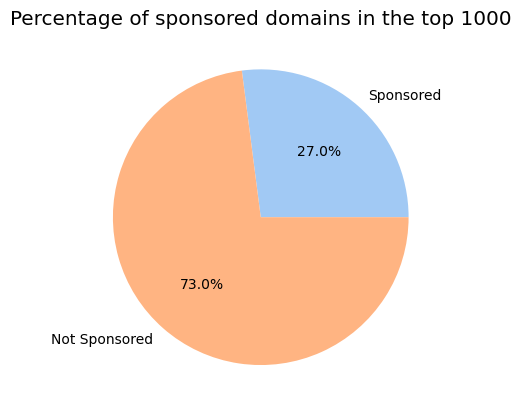

In [16]:
sp_domains_cnt = [row[1] for row in domains_top_classified.groupBy('is_sponsored').count().collect()]

colors = sns.color_palette('pastel')
plt.pie(sp_domains_cnt, labels=['Sponsored', 'Not Sponsored'], autopct='%1.1f%%', colors=colors)
plt.title('Percentage of sponsored domains in the top 1000')
plt.show()

In [17]:
sp_domains = domains_top_classified.filter(domains_top_classified.is_sponsored)
nsp_domains = domains_top_classified.filter(~domains_top_classified.is_sponsored)

In [22]:
sp_domains.show()

+------------------+-------+--------------------+------------+---------------+
|            domain|  count|median_sponsor_score|is_sponsored|domain_category|
+------------------+-------+--------------------+------------+---------------+
|   play.google.com|2093786|                   4|        true|    Application|
|         rstyle.me|1175073|                  11|        true|         Agency|
|             po.st| 739548|                   4|        true|         Agency|
|     teespring.com| 705812|                   4|        true|         Agency|
|       go.magik.ly| 691020|                  14|        true|         Agency|
|    streamlabs.com| 540814|                   4|        true|    Application|
|           geni.us| 527355|                   8|        true|         Agency|
|           g2a.com| 335453|                   6|        true|     Video Game|
|       studyiq.com| 306996|                  19|        true|      Education|
|          etsy.com| 296379|                   6|   

In [40]:
# Get the mean of the median sponsor score for sponsored and not sponsored domains
sp_domains_avg_score = sp_domains.select('median_sponsor_score').collect()
sp_domains_avg_score = [c[0] for c in sp_domains_avg_score]
sp_domains_avg_score = np.mean(sp_domains_avg_score)
sp_domains_avg_score

nsp_domains_avg_score = nsp_domains.select('median_sponsor_score').collect()
nsp_domains_avg_score = [c[0] for c in nsp_domains_avg_score]
nsp_domains_avg_score = np.mean(nsp_domains_avg_score)

print(f"The average median sponsor score for sponsored domains is {sp_domains_avg_score:.2f} and for not sponsored domains is {nsp_domains_avg_score:.2f}.")
print(f"The difference between the two is {sp_domains_avg_score - nsp_domains_avg_score:.2f}.")

The average median sponsor score for sponsored domains is 8.30 and for not sponsored domains is 3.92.
The difference between the two is 4.38.


As a sanity check, we can see that the mean sponsor score of the domains classified as sponsored-related is higher than the mean sponsor score of the domains classified as not sponsored-related. We indeed expect that the domains classified as sponsored-related have a higher sponsor score than the domains classified as not sponsored-related, and used this as a criterion to classify the domains.

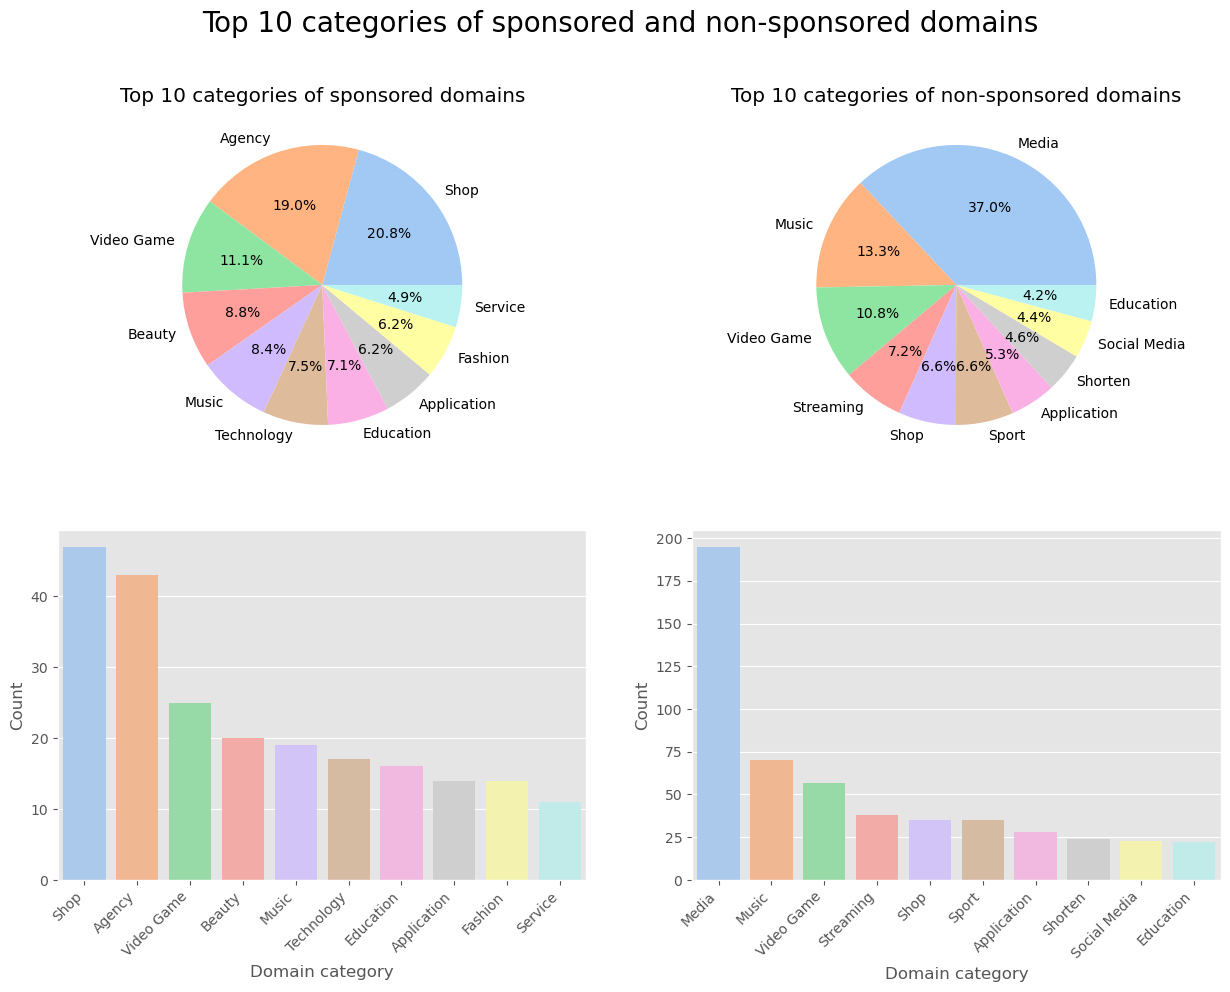

In [44]:
classified_sp_domains_cnt = [(row.domain_category, row[1]) for row in sp_domains.groupBy('domain_category').count().collect()]
classified_sp_domains_cnt = sorted(classified_sp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_sp_domains_cnt = classified_sp_domains_cnt[:10]

classified_nsp_domains_cnt = [(row.domain_category, row[1]) for row in nsp_domains.groupBy('domain_category').count().collect()]
classified_nsp_domains_cnt = sorted(classified_nsp_domains_cnt, key=lambda x: x[1], reverse=True)
classified_nsp_domains_cnt = classified_nsp_domains_cnt[:10]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.pie(x=[x[1] for x in classified_sp_domains_cnt], labels=[x[0] for x in classified_sp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax1.set_title('Top 10 categories of sponsored domains')

ax2.pie(x=[x[1] for x in classified_nsp_domains_cnt], labels=[x[0] for x in classified_nsp_domains_cnt], autopct='%1.1f%%', colors=colors)
ax2.set_title('Top 10 categories of non-sponsored domains')

sns.barplot(x=[x[0] for x in classified_sp_domains_cnt], y=[x[1] for x in classified_sp_domains_cnt], ax=ax3, palette=colors)
ax3.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax3.get_xticklabels(), rotation=45, horizontalalignment='right')

sns.barplot(x=[x[0] for x in classified_nsp_domains_cnt], y=[x[1] for x in classified_nsp_domains_cnt], ax=ax4, palette=colors)
ax4.set(xlabel='Domain category', ylabel='Count')
plt.setp(ax4.get_xticklabels(), rotation=45, horizontalalignment='right')

fig.suptitle('Top 10 categories of sponsored and non-sponsored domains', fontsize=20)
plt.show()

We can see that sponsored domains and non-sponsored domains are not equally distributed among the classes. Indeed, about a half of sponsored domains are related to **shops**, **agencies** and **video games**. On the other hand, **Media** and **Music** are the most popular classes for non-sponsored domains, where half of the domains are related to these classes.

These results make sense as many YouTubers are helped by agencies to develop their content and monetize it. They mainly sponsor products related to video games, beauty and shops.

Medias are the most popular class for non-sponsored domains. This may be due to the fact that YouTube is used by many medias, news and TV channels to share their content via their own YouTube channel without actually sponsoring it. Music is also a popular class for non-sponsored domains because YouTubers should always link to the original music they use in their videos.